In [1]:
%load_ext autoreload

In [2]:
%autoreload 

import os
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [3]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'
# output_dir = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/'
# fig_dir    = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/figs/'

# Choose to load data (True) or start a new scan (False)
load_data = True

# Scan over parameters, or load previous data

In [4]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [5]:
### Parameters
start_rs, high_rs, end_rs = 3e3, 1.555e3, 4
cf = 16
rtol = 1e-6
nmax = 10 # maximum number of hydrogen levels to track
iter_max = 5 # number of times to iterate over recombination/ionization rates

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']

In [12]:
if load_data == True:
    data_list = []
    #dir_str = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/max_CMB_nmax_200_Puchwein/'
    dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs/'
    
    directory = os.fsencode(dir_str)
    skip = 4

    for file in tqdm(sorted(os.listdir(directory))[::skip]): 
        filename = os.fsdecode(file)
        data_list.append(pickle.load(open(dir_str+filename, 'rb')))
else:
    # Scan over models and mass ranges
    data = {}

    # We use the iterative method.
    # First solve the evolution equations assuming Recfast's
    # alpha_B and beta_B rates (e.g. by setting recfast_TLA = True).
    # One output is the a new, more accurate set of rates
    # These rates can then be plugged back into the MLA equations
    # Continued iteration leads to more accurate rates
    # but this process converges quickly (after one iteration)
    for iteration in range(iter_max):
        print('~~~Iteration ', iteration, '~~~')
        data[iteration] = {model : [] for model in models}
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'swave']:
                model = pri+'_'+DM_process
                print('starting', model)

                if pri=='elec':
                    if DM_process=='decay':
                        mDM_list = 2*(10**log10eng + phys.me)
                    else:
                        mDM_list = 10**log10eng + phys.me
                elif pri=='phot':
                    if DM_process=='decay':
                        mDM_list = 2*10**log10eng
                    else:
                        mDM_list = 10**log10eng

                for mi, mDM in enumerate(tqdm(mDM_list[3:])):     
                    param = param_bound(mDM, DM_process, pri)

                    # If this is first iteration, use Recfast TLA rates
                    if iteration == 0:
                        TLA_switch = True
                        MLA_funcs = None
                    # For subsequent iterations, use rates calculated from previous run
                    else:
                        TLA_switch = False
                        rates = data[iteration-1][model][mi]['MLA']
                        MLA_funcs = [interp1d(rates[0], rates[i], fill_value='extrapolate')
                            for i in range(1,4)]

                    print('i get here?')
                    print(DM_process, mDM, param, pri, start_rs, high_rs, end_rs, cf, TLA_switch, MLA_funcs, nmax, rtol)

                    goods = main.evolve(
                        DM_process=DM_process, mDM=mDM,
                        lifetime=param, sigmav = param,
                        primary=pri+'_delta',
                        start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
                        reion_switch=True, reion_method='Puchwein', heat_switch=True,
                        coarsen_factor=cf,
                        distort=True, recfast_TLA=TLA_switch, MLA_funcs=MLA_funcs,
                        fexc_switch = True, reprocess_distortion=True, 
                        nmax=nmax, rtol=rtol
                    )
                    
                    # Add the data for this iteration, model, and mass point
                    data[iteration][model].append(goods)
                    pickle.dump(data, open(output_dir+f'scans_nmax{nmax}.dat','wb'))

# Plot all distortions

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


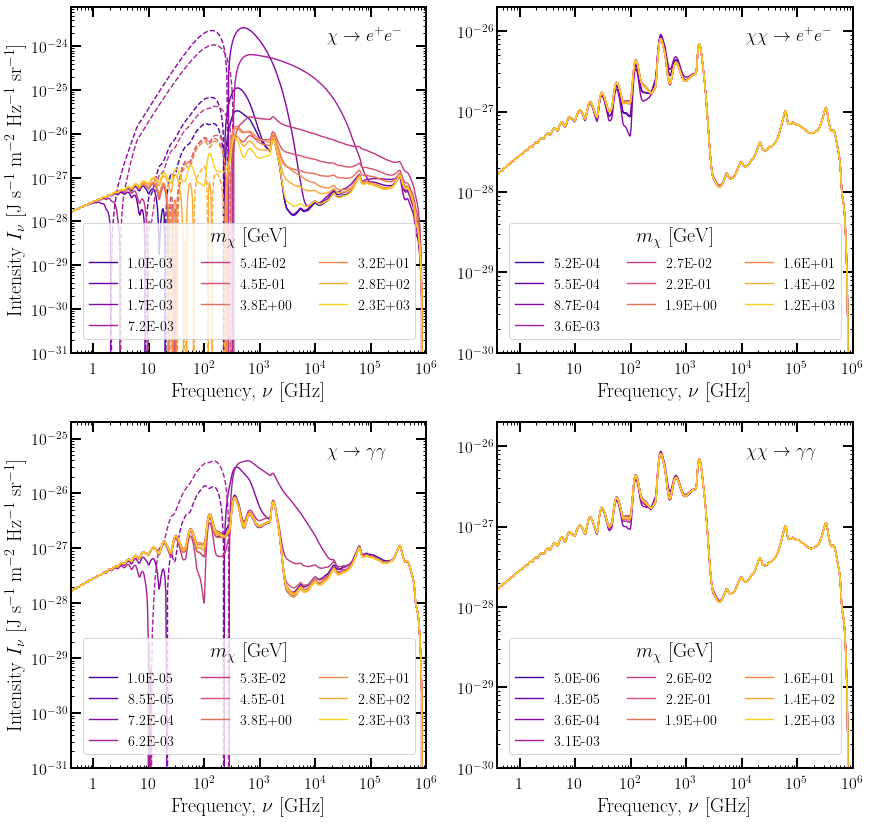

In [13]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40/skip))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'Intensity $I_{\nu}$ '
        +'[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4e-1, 1e6])
        axs[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                axs[i][j].set_ylim([1e-31, 8e-24])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].set_ylim([1e-31, 2e-25])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        k = 0 

        for data in data_list:
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 

                axs[i][j].plot(
                    nu/1e9, convert * data['data'][-1]['distortion'].dNdE,
                    color=cmap[k], linestyle='solid', linewidth=1.4, label=f"{data['DM_params']['mDM']/1e9:.1E}"
                )
                axs[i][j].plot(
                    nu/1e9, -convert * data['data'][-1]['distortion'].dNdE,
                    color=cmap[k], linestyle='--', linewidth=1.4,
                )
                k += 1

        axs[i][j].legend(title=r'$m_\chi$ [GeV]', loc='lower center', fontsize=14, ncol=3)
#plt.savefig(fig_dir+'distortion_grid.pdf')

# Distortion contribution as a function of redshift

In [27]:
rs_list = data_list[0]['data'][-1]['rs']
print(data_list[2]['DM_params'])
print(data_list[11]['DM_params'])

{'pri': 'elec', 'DM_process': 'decay', 'mDM': 1746775.5464866608, 'inj_param': 2.0192269772200676e+24}
{'pri': 'elec', 'DM_process': 'swave', 'mDM': 553565.8868990175, 'inj_param': 6.711640184699321e-31}


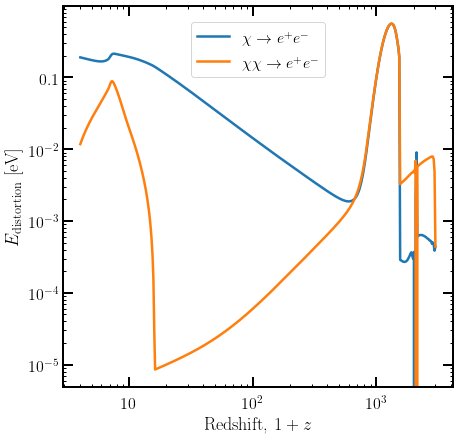

In [37]:
plt.figure(figsize=(7,7))
plt.loglog()
plt.plot(rs_list, data_list[2]['data'][-1]['distortions'].toteng(), label=r'$\chi \rightarrow e^+ e^-$')
plt.plot(rs_list, data_list[11]['data'][-1]['distortions'].toteng(), label=r'$\chi\chi \rightarrow e^+ e^-$')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'$E_\mathrm{distortion}$ [eV]')
plt.legend()
plt.show()

# Show convergence with each iteration

In [34]:
print(data_list[3]['DM_params'])
np.log10(5.874749381475837e+24)

{'pri': 'elec', 'DM_process': 'decay', 'mDM': 7192310.325897368, 'inj_param': 5.874749381475837e+24}


24.76898934420953

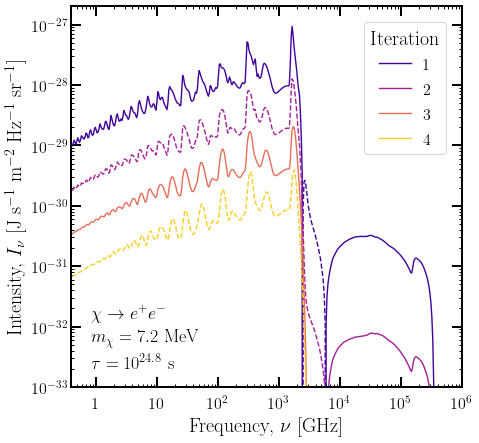

In [37]:
iter_max = len(data_list[3]['data'])-1
cmap = cm.plasma(np.linspace(0.1, 0.9, iter_max))

plt.figure(figsize=(7,7))
ax = plt.gca()
# plt.loglog()
plt.xscale('log')

for ii in range(iter_max):
    plot_distortion(ax, data_list[3]['data'][ii+1], run2=data_list[3]['data'][ii], label=f'{ii+1}',
                    color=cmap[ii], leg=True, first=False, diff=True)
plt.ylim(1e-33,2e-27)
plt.legend(title='Iteration')
plt.text(0.05, 0.18, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.11, r'$m_\chi = 7.2$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.05, r'$\tau = 10^{24.8}$ s', fontsize=18, transform = ax.transAxes)

plt.savefig(fig_dir+'iterations.pdf')
plt.show()